In [9]:
import pandas as pd
import sys

df = pd.read_csv("../dataset/Delaware.csv")
# df = df[df.REGION == "New York"]

df_use = df[["REGION", "YEAR", "WEEK", "ili_ratio"]]
df_use.index = range(len(df_use))

df_use = (df_use.loc[:, ["ili_ratio"]])  # 只用ili_ratio

In [10]:
df = pd.read_csv("../dataset/Delaware.csv")
# df = df[df.REGION == "Delaware"]

df_use = df[["REGION", "YEAR", "WEEK", "ili_ratio"]]
df_use.index = range(len(df_use))

df_use = (df_use.loc[:, ["ili_ratio"]])  # 只用ili_ratio
df_use

,ili_ratio
0,0.001001
1,0.003686
2,0.003370
3,0.004605
4,0.002223
...,...
624,0.011423
625,0.009824
626,0.009270
627,0.012565


In [11]:
df = pd.read_csv("../dataset/covid19/france_new_cases.csv")

df_use = df[["New_cases"]]
df_use = df_use[:660]
df_use.index = range(len(df_use))

df_use

,New_cases
0,73
1,133
2,184
3,107
4,410
...,...
655,48473
656,14684
657,72634
658,79567


In [13]:
df = pd.read_csv("../dataset/covid19/france_new_cases _temp.csv")

df_use = df[["New_cases", "tavg"]]
df_use = df_use[:600]
df_use.index = range(len(df_use))

df_use

,New_cases,tavg
0,73,9.1
1,133,7.4
2,184,7.8
3,107,8.9
4,410,8.5
...,...,...
595,5796,14.0
596,5498,11.2
597,6058,10.4
598,6169,10.4


In [6]:
df = pd.read_csv('../dataset/elec/oneminute.csv')

df_use = df[['p']]
df_use.index = range(len(df_use))
df_use = df_use[:500]

In [60]:
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import numpy as np
import torch


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)


def nn_seq_us(batch_size, step):
    print('data processing...')
    dataset = df_use
    # split
    train = dataset[:int(len(dataset) * 0.6)]
    val = dataset[int(len(dataset) * 0.6):int(len(dataset) * 0.85)]
    test = dataset[int(len(dataset) * 0.85):len(dataset)]
    m, n = np.max(train[train.columns[0]]), np.min(train[train.columns[0]])

    def process(data, batch_size, shuffle):
        load = data[data.columns[:]]
        load = load.values
        data = data.values.tolist()
        load = (load - n) / (m - n)

        # load = data[data.columns[0]]
        # load = load.tolist()
        # data = data.values.tolist()
        # load = (load - n) / (m - n)

        seq = []
        for i in range(len(data) - step):
            train_seq = []
            train_label = []
            for j in range(i, i + step):
                x = [load[j]]
                train_seq.append(x)
            # for c in range(2, 8):
            #     train_seq.append(data[i + step][c])
            train_label.append(load[i + step])
            train_seq = torch.FloatTensor(train_seq)
            train_label = torch.FloatTensor(train_label).view(-1)
            seq.append((train_seq, train_label))

        # print(seq[-1])
        seq = MyDataset(seq)
        seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=True)

        return seq

    data_train = process(train, batch_size, True)
    data_validate = process(val, batch_size, True)
    data_test = process(test, batch_size, False)

    return data_train, data_validate, data_test, m, n


import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, device):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1  # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

        self.device = device

    def forward(self, input_seq):
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0))  # output(5, 30, 64)
        pred = self.linear(output)  # (5, 30, 1)
        pred = pred[:, -1, :]  # (5, 1)
        return pred


from torch.optim.lr_scheduler import StepLR as StepLR
from tqdm import tqdm
from copy import deepcopy


def get_val_loss(model, Val, loss_function, device):
    model.eval()
    val_loss = []
    for (seq, label) in Val:
        seq = seq.to(device)
        label = label.to(device)
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        val_loss.append(loss.item())

    return sum(val_loss) / len(val_loss)  # MSE


def lstm_train(data_train, Val, path, input_size=1, hidden_size=10, num_layers=2, output_size=1, batch_size=5,
               optimizer='adam', max_epochs=20, lr=0.01,
               device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    weight_decay = 0.0001
    step_size = 5
    gamma = 0.1

    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=batch_size, device=device).to(device)

    loss_function = nn.MSELoss().to(device)
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                                     weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=0.9, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 5

    min_train_loss = 10086
    loss = 10

    for epoch in range(max_epochs):
        train_loss = []
        for (seq, label) in data_train:
            seq = seq.to(device)
            seq.resize_(batch_size, step, input_size)  # (1, 18, 1, 2) -> (1, 18, 2)

            label = label.to(device)
            y_pred = model(seq)

            loss = loss_function(y_pred, label[:, 0].unsqueeze(1))
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()

        # # validation
        # val_loss = get_val_loss(model, Val, loss_function, device)
        # if epoch > min_epochs and val_loss < min_val_loss:
        #     min_val_loss = val_loss
        #     best_model = deepcopy(model)
        #
        # if epoch % 10 == 0:
        #     print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))

        if epoch > min_epochs and loss < min_train_loss:
            min_train_loss = loss
            best_model = deepcopy(model)
            print(type(model))

        if epoch % 10 == 0:
            print('epoch {:03d} train_loss {:.8f}'.format(epoch, np.mean(train_loss)))

        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)


from itertools import chain
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


def get_mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum((y_true - y_pred) ** 2) / len(y_true)


def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# def lstm_test(data_test, path, m, n, input_size = 1,  hidden_size = 10, num_layers = 2, output_size = 1, batch_size = 5, device = torch.device('cpu')):
def lstm_test(data_test, path, m, n, input_size, hidden_size, num_layers, output_size, batch_size, device):
    pred = []
    y = []
    print('loading models...')

    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=batch_size, device=device).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for (seq, target) in data_test:
        target = list(chain.from_iterable(target[:, 0].unsqueeze(1).data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        seq.resize_(batch_size, step, input_size)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    print('mape:', get_mape(y, pred))
    print('mse:', get_mse(y, pred))

    # plot
    x = [i for i in range(1, y.shape[0] + 1)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    # plt.savefig("./new.png")
    plt.show()


def future_lstm_test(data_test, path, m, n, input_size, hidden_size, num_layers, output_size, batch_size, device):
    predict_length = 30
    pred = []
    y = []
    print('loading models...')

    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=batch_size, device=device).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')

    y_pred = 0
    seq = []
    label = []
    ss = [(seq, target) for (seq, target) in data_test]
    # print(ss)

    # ss = []
    # for (seq, target) in data_test:
    #     target = list(chain.from_iterable(target[:, 0].unsqueeze(1).data.tolist()))
    #     ss.append((ss, seq))

    for i in range(len(ss)):
        label.append(ss[i][1][0])

    y = label

    # label = list(chain.from_iterable(label.tolist()))
    ss = ss[0]
    # print(ss)
    for i in range(predict_length):

        seq = ss[0]
        seq.resize_(batch_size, step, input_size)

        with torch.no_grad():
            y_pred = model(seq)
            # print(f'seq{seq};')
            for i in range(len(seq[0]) - 1):
                seq[0][i] = seq[0][i + 1]
            seq[0][-1] = y_pred
            # print(f'pred: {y_pred}')
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    # print(f'y_pred is {y_pred}')

    y = []
    for i in range(len(label)):
        y.append(label[i].detach().numpy()[0])

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    # print('mape:', get_mape(y, pred))
    # print('mse:', get_mse(y, pred))
    print(len(y))
    print(len(pred))

    # plot
    # x = [i for i in range(1, y.shape[0] + 1)]
    x = [i for i in range(1, predict_length + 1)]
    x_smooth = np.linspace(np.min(x), np.max(x), 900)
    y_smooth = make_interp_spline(x, y[:predict_length])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    # x = [i for i in range(1, pred.shape[0] + 1)]
    x = [i for i in range(1, predict_length + 1)]
    y_smooth = make_interp_spline(x, pred[:predict_length])(x_smooth)
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    # plt.savefig("./new.png")
    plt.show()



In [55]:
input_size = 2
hidden_size = 64
num_layers = 2
output_size = 1
batch_size = 1
optimizer = 'adam'
max_epochs = 50
# lr = 0.05
lr = 0.01  # mape:14.~    train_loss: 0.0037~

step = 24

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

model_path = '../lstm_model/best_model_lstm.model'

data_train, data_validate, data_test, m, n = nn_seq_us(batch_size=batch_size, step=step)

lstm_train(data_train, data_validate, model_path, input_size, hidden_size, num_layers, output_size, batch_size,
           optimizer, max_epochs, lr, device)

cpu
data processing...
epoch 000 train_loss 0.03992418
epoch 010 train_loss 0.01310721
<class '__main__.LSTM'>
<class '__main__.LSTM'>
<class '__main__.LSTM'>
epoch 020 train_loss 0.01275033
epoch 030 train_loss 0.01274781
epoch 040 train_loss 0.01274755


loading models...
predicting...
mape: 143.48495176085336
mse: 15854445.599661337


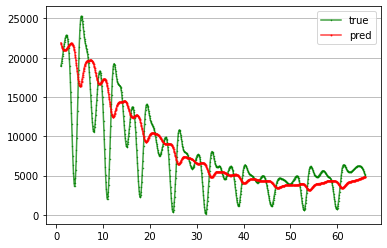

In [56]:
lstm_test(data_test, model_path, m, n, input_size, hidden_size, num_layers, output_size, batch_size, device)

loading models...
predicting...
66
30


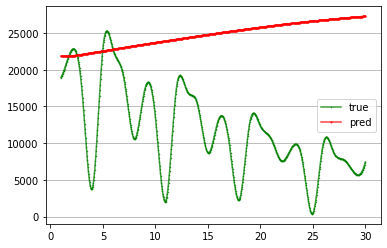

In [61]:
future_lstm_test(data_test, model_path, m, n, input_size, hidden_size, num_layers, output_size, batch_size, device)